In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
from pytorch_transformers import BertTokenizer

In [3]:
#%%bash
#pip install pytorch-pretrained-bert

In [4]:
SEED_NUM = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
seed_all(SEED_NUM)

In [5]:
device='cuda'
torch.cuda.set_device(4)

In [6]:
from sklearn.model_selection import train_test_split

DATA_ROOT = Path("") 

train_pre, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["task2_trainset.csv", "task2_public_testset.csv"]]
####### add dataset pseudo label
#dataset = pd.read_csv('dataset.csv')
###### add dataset pseudo label
dataset = pd.read_csv('dataset_predictions.csv')

In [7]:
train_pre.drop('Title',axis=1,inplace=True)
train_pre.drop('Categories',axis=1,inplace=True)
test.drop('Title',axis=1,inplace=True)
test.drop('Categories',axis=1,inplace=True)
####################################################
train_pre.drop('Created Date',axis=1, inplace=True)
train_pre.drop('Authors',axis=1,inplace=True)
test.drop('Created Date',axis=1, inplace=True)
test.drop('Authors',axis=1,inplace=True)

In [8]:
train_pre['THEORETICAL']=0
train_pre['ENGINEERING']=0
train_pre['EMPIRICAL']=0
train_pre['OTHERS']=0
for i in range(train_pre.Id.count()):
    string = train_pre['Task 2'][i]
    train_pre['THEORETICAL'][i] = 1 if (string.find('THEORETICAL')!=-1) else 0
    train_pre['ENGINEERING'][i] = 1 if (string.find('ENGINEERING')!=-1) else 0
    train_pre['EMPIRICAL'][i] = 1 if (string.find('EMPIRICAL')!=-1) else 0
    train_pre['OTHERS'][i] = 1 if (string.find('OTHERS')!=-1) else 0   
train_pre.head()

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/IPL915/.co

,Id,Abstract,Task 2,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
0,D00001,Rapid popularity of Internet of Things (IoT) a...,THEORETICAL,1,0,0,0
1,D00002,"In this paper, we address the problem of compu...",THEORETICAL,1,0,0,0
2,D00003,High quality upsampling of sparse 3D point clo...,ENGINEERING,0,1,0,0
3,D00004,Internet is the main source of information now...,EMPIRICAL,0,0,1,0
4,D00005,Automated Facial Expression Recognition (FER) ...,ENGINEERING,0,1,0,0


In [9]:
train_pre.drop('Task 2',axis=1,inplace=True)
train_pre

,Id,Abstract,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
0,D00001,Rapid popularity of Internet of Things (IoT) a...,1,0,0,0
1,D00002,"In this paper, we address the problem of compu...",1,0,0,0
2,D00003,High quality upsampling of sparse 3D point clo...,0,1,0,0
3,D00004,Internet is the main source of information now...,0,0,1,0
4,D00005,Automated Facial Expression Recognition (FER) ...,0,1,0,0
...,...,...,...,...,...,...
6995,D06996,We have witnessed the discovery of many techni...,1,1,0,0
6996,D06997,State-of-the-art slot filling models for goal-...,0,1,0,0
6997,D06998,Real-time semantic segmentation plays an impor...,0,1,0,0
6998,D06999,We propose a neural embedding algorithm called...,1,0,1,0


In [10]:
#train = train_pre.append(dataset)
#train.reset_index(inplace=True,drop=True)
train = train_pre.copy()

In [11]:
def text_clean(df1):    
    for index,row in df1.iterrows():
        row['Abstract']=row['Abstract'].replace("$$$", " ")
        #df1['Abstract'][i]=df1['Abstract'][i].replace(".", " ")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("->", "to")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("~", " ")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("&", "and")
        #df1['Abstract'][i]=df1['Abstract'][i].replace(",", " ")
        #df1['Abstract'][i]=df1['Abstract'][i].replace(":", " ")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("%", " percentage")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("C++", "c plus plus")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("w.r.t.", "in respect of")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("e.g.", "example")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("etc.", "and so on")
        #df1['Abstract'][i]=df1['Abstract'][i].replace("'s'", "s")       
        row['Abstract']=row['Abstract'].replace("(A)", " ")
        row['Abstract']=row['Abstract'].replace("(B)", " ")
        row['Abstract']=row['Abstract'].replace("(C)", " ")
        row['Abstract']=row['Abstract'].replace("(D)", " ")
        row['Abstract']=row['Abstract'].replace("(a)", " ")
        row['Abstract']=row['Abstract'].replace("(b)", " ")
        row['Abstract']=row['Abstract'].replace("(c)", " ")
        row['Abstract']=row['Abstract'].replace("(d)", " ")
        row['Abstract']=row['Abstract'].replace("(e)", " ")
        row['Abstract']=row['Abstract'].replace("(1)", " ")
        row['Abstract']=row['Abstract'].replace("(2)", " ")
        row['Abstract']=row['Abstract'].replace("(3)", " ")
        row['Abstract']=row['Abstract'].replace("(4)", " ")
        row['Abstract']=row['Abstract'].replace("(5)", " ")
        row['Abstract']=row['Abstract'].replace("(i)", " ")
        row['Abstract']=row['Abstract'].replace("(ii)", " ")
        row['Abstract']=row['Abstract'].replace("(iii)", " ")
        row['Abstract']=row['Abstract'].replace("(iv)", " ")
        row['Abstract']=row['Abstract'].replace("i)", " ")
        row['Abstract']=row['Abstract'].replace("ii)", " ")
        row['Abstract']=row['Abstract'].replace("iii)", " ")
        row['Abstract']=row['Abstract'].replace("iv)", " ")
        row['Abstract']=row['Abstract'].replace("(", " ")
        row['Abstract']=row['Abstract'].replace(")", " ")
text_clean(train)
text_clean(test)

In [12]:
train, val = train_test_split(train, shuffle=True, test_size=0.2, random_state=SEED_NUM)

In [13]:
train.head()

,Id,Abstract,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
1032,D01033,"Many computer vision applications, such as obj...",1,1,0,0
6339,D06340,Many experimental proposals for noisy intermed...,1,0,0,0
3886,D03887,In the present paper we describe the technolog...,0,1,0,0
2653,D02654,An important property of programming language ...,1,0,0,0
6914,D06915,Multilingual topic models enable crosslingual ...,0,1,0,0


In [14]:
train['Abstract'][0]

'Rapid popularity of Internet of Things (IoT) and cloud computing permits neuroscientists to collect multilevel and multichannel brain data to better understand brain functions, diagnose diseases, and devise treatments.$$$To ensure secure and reliable data communication between end-to-end (E2E) devices supported by current IoT and cloud infrastructure, trust management is needed at the IoT and user ends.$$$This paper introduces a Neuro-Fuzzy based Brain-inspired trust management model (TMM) to secure IoT devices and relay nodes, and to ensure data reliability.$$$The proposed TMM utilizes node behavioral trust and data trust estimated using Adaptive Neuro-Fuzzy Inference System and weighted-additive methods respectively to assess the nodes trustworthiness.$$$In contrast to the existing fuzzy based TMMs, the NS2 simulation results confirm the robustness and accuracy of the proposed TMM in identifying malicious nodes in the communication network.$$$With the growing usage of cloud based Io

In [15]:
val.head()

,Id,Abstract,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
6500,D06501,In this paper we present the Creative Inventio...,0,0,0,1
2944,D02945,Computer algorithms are written with the inten...,0,1,0,0
2024,D02025,The problem of finding the maximum number of v...,1,0,0,0
263,D00264,Real-world machine learning applications often...,1,0,0,0
4350,D04351,Typically an ontology matching technique is a ...,0,0,1,0


In [16]:
test.head()

,Id,Abstract
0,T00001,Mobile Crowdsensing is a promising paradigm fo...
1,T00002,A keyboard has many function keys and each fun...
2,T00003,With increasing availability of communication ...
3,T00004,The clustered planarity problem c-planarity ...
4,T00005,We introduce a genetic programming method for ...


In [17]:
###### pseudo label
#dataset.head()


In [18]:
###### pseudo label
#del test
#test.head()

In [19]:
seed_all(SEED_NUM)

In [20]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,    
    roberta_model_name='bert-large-uncased', # roberta-basecan also be exchnaged with roberta-large 
    max_lr=1e-5,
    epochs=4,
    use_fp16=True,
    bs=32, 
    max_seq_len=330, 
    num_labels = 6,
    hidden_dropout_prob=.05,
    hidden_size=1024, # 1024 for roberta-large 768 for base
    start_tok = "[CLS]",
    end_tok = "[SEP]",
)

In [21]:
label_cols  = ["THEORETICAL", "ENGINEERING", "EMPIRICAL", "OTHERS"]
feat_cols  = ["Abstract"]


In [22]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return  [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [23]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In following code snippets, we need to wrap BERT vocab and BERT tokenizer with Fastai modules

In [24]:
roberta_tok = BertTokenizer.from_pretrained(
    config.roberta_model_name,
)
fastai_roberta_vocab = Vocab(list(roberta_tok.vocab.keys()))

In [25]:


fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [26]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

In [27]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_roberta_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_roberta_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In this project, we will be using Databunch which is easier to create and use.

In [28]:
# this will produce a virtually identical databunch to the code above
data = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_roberta_vocab,
                  text_cols=feat_cols,
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )


In [29]:
data.show_batch()

text,target
"[CLS] objective image quality assessment ( iq ##a ) is imperative in the current multimedia - intensive world , in order to assess the visual quality of an image at close to a human level of ability . $ $ $ many ~ parameters such as color intensity , structure , sharp ##ness , contrast , presence of an object , etc . , draw human attention to an image",ENGINEERING;EMPIRICAL
"[CLS] the behavior of het ##ero ##gen ##eous multi - agent systems is studied when the coupling matrices are possibly all different and / or singular ( that is , its rank is less than the system dimension ) . $ $ $ rank - def ##icient coupling allows exchange of limited state information , which is suitable for study of output coupling in multi - agent systems . $",THEORETICAL
"[CLS] reviews spa ##ms are prevalent in e - commerce to manipulate product ranking and customers decisions malicious ##ly . $ $ $ while spa ##ms generated based on simple spa ##mming strategy can be detected effectively , hardened spa ##mmer ##s can evade regular detectors via more advanced spa ##mming strategies . $ $ $ previous work gave more attention to eva ##sion against text and graph - based",ENGINEERING
"[CLS] prediction of new drug - target interactions is extremely important as it can lead the researchers to find new uses for old drugs and to realize the therapeutic profiles or side effects thereof . $ $ $ however , experimental prediction of drug - target interactions is expensive and time - consuming . $ $ $ as a result , computational methods for prediction of new drug - target",ENGINEERING;EMPIRICAL
"[CLS] a new scheme to sample signals defined in the nodes of a graph is proposed . $ $ $ the underlying assumption is that such signals admit a sparse representation in a frequency domain related to the structure of the graph , which is captured by the so - called graph - shift operator . $ $ $ most of the works that have looked at this problem have",THEORETICAL


# Model

In [30]:
#seed_all(SEED_NUM)
seed_all(SEED_NUM)

In [31]:
#from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
#bert_model = BertForSequenceClassification.from_pretrained(config.roberta_model_name, num_labels=4)

In [32]:
loss_func = nn.BCEWithLogitsLoss()

In [33]:
import torch.nn as nn
from pytorch_transformers import BertModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=4):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = BertModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits
roberta_model = CustomRobertaModel()

In [34]:


learn = Learner(data,roberta_model,loss_func=loss_func,metrics=[fbeta],callback_fns=ShowGraph)

In [35]:
if config.use_fp16: learn=learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


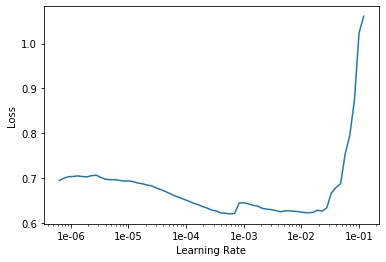

In [36]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,fbeta,time
0,0.508728,0.449917,0.754901,01:41
1,0.421096,0.407989,0.786748,01:40
2,0.380896,0.396260,0.791378,01:41
3,0.364180,0.395076,0.794893,01:41


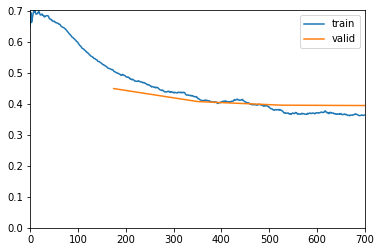

In [37]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(4, max_lr=config.max_lr)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.523629,0.452935,0.762702,01:33
1,0.429912,0.406468,0.788653,01:33
2,0.389382,0.395048,0.796969,01:33
3,0.351822,0.390833,0.797975,01:34


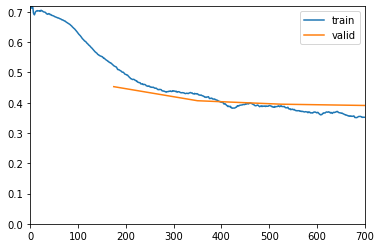

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.554719,0.487613,0.750036,01:35
1,0.430355,0.422173,0.782328,01:33
2,0.383484,0.397872,0.793345,01:33
3,0.363030,0.397531,0.798589,01:32


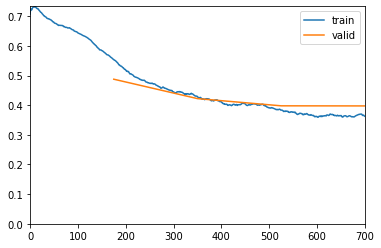

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.510234,0.442809,0.760489,01:33
1,0.419322,0.399615,0.799351,01:33
2,0.384876,0.392509,0.798578,01:33
3,0.359112,0.391426,0.800910,01:33


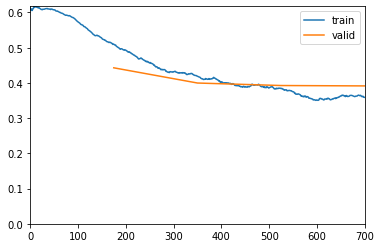

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.526983,0.450511,0.767608,01:36
1,0.430011,0.409931,0.790396,01:33
2,0.395028,0.394828,0.793855,01:33
3,0.366371,0.394604,0.796343,01:33


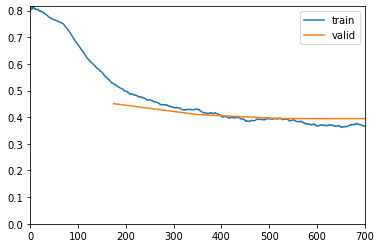

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.489622,0.448238,0.763858,01:33
1,0.426858,0.409887,0.780266,01:33
2,0.380996,0.394497,0.793002,01:38
3,0.351063,0.395060,0.797292,01:33


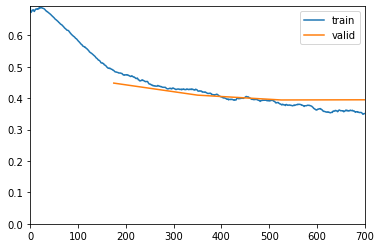

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.531542,0.464173,0.763542,01:33
1,0.429653,0.425374,0.785988,01:34
2,0.392301,0.395061,0.795165,01:33
3,0.360354,0.393529,0.796858,01:36


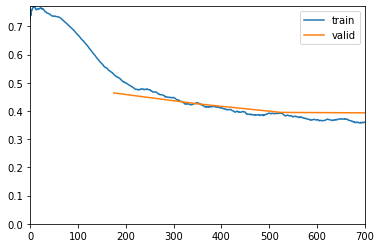

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.508022,0.449190,0.759199,01:34
1,0.425336,0.400772,0.790297,01:33
2,0.380696,0.393569,0.799175,01:33
3,0.344126,0.393093,0.799759,01:33


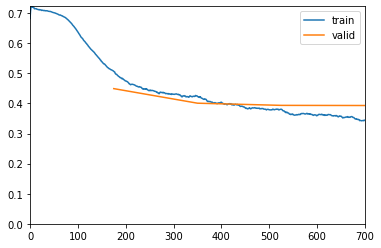

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.501361,0.455542,0.768708,01:33
1,0.421882,0.404933,0.791330,01:34
2,0.389828,0.394146,0.794482,01:33
3,0.358034,0.392419,0.800648,01:34


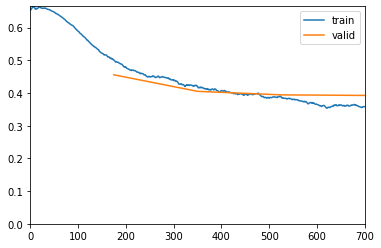

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.517874,0.464424,0.743882,01:33
1,0.424184,0.410836,0.787426,01:33
2,0.380978,0.398401,0.794995,01:34
3,0.357283,0.393837,0.800380,01:34


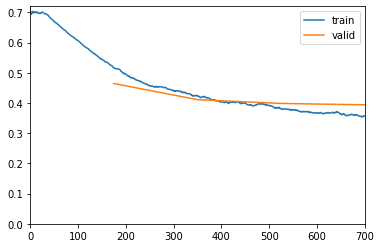

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.520507,0.455460,0.753185,01:33
1,0.418837,0.405384,0.794002,01:32
2,0.391871,0.393638,0.804787,01:34
3,0.380838,0.390442,0.801418,01:33


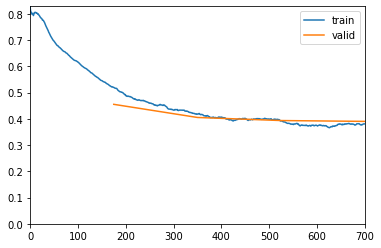

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.525881,0.455762,0.758184,01:34
1,0.438245,0.405292,0.786424,01:33
2,0.408188,0.392289,0.796754,01:34
3,0.374630,0.391806,0.796458,01:33


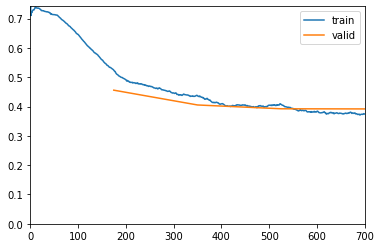

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.545950,0.473112,0.746270,01:33
1,0.439730,0.407570,0.782920,01:33
2,0.386985,0.395397,0.797708,01:34
3,0.364582,0.393705,0.799178,01:34


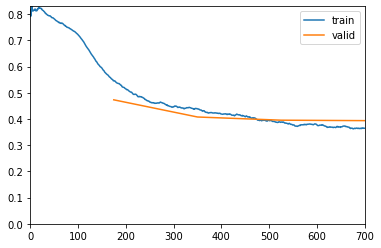

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.504025,0.459266,0.762454,01:33
1,0.425289,0.409400,0.790014,01:33
2,0.379039,0.395967,0.799298,01:33
3,0.365224,0.390761,0.799747,01:33


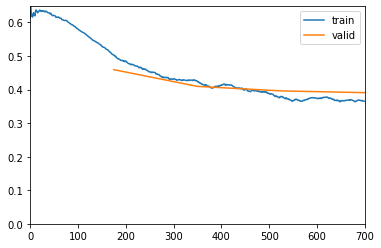

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.505915,0.450643,0.755074,01:34
1,0.431407,0.405928,0.792079,01:33
2,0.395045,0.392936,0.797871,01:33
3,0.364477,0.393370,0.799354,01:36


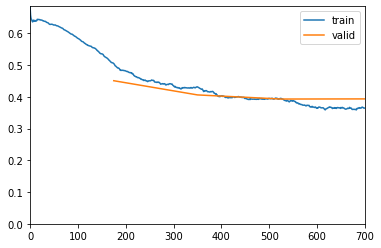

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.517910,0.457411,0.746908,01:33
1,0.429408,0.406967,0.793898,01:33
2,0.384258,0.391344,0.795966,01:33
3,0.355045,0.390512,0.799030,01:34


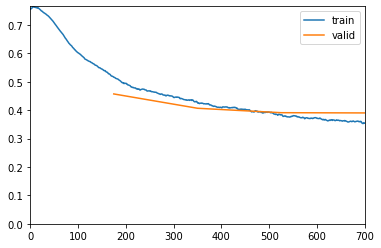

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.503676,0.451218,0.758732,01:33
1,0.427628,0.405893,0.794454,01:33
2,0.386644,0.391746,0.799567,01:33
3,0.360991,0.392108,0.799597,01:33


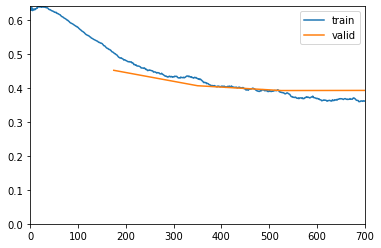

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.552423,0.496106,0.740755,01:33
1,0.440906,0.412410,0.787873,01:33
2,0.400215,0.398998,0.795840,01:34
3,0.360748,0.395241,0.795115,01:33


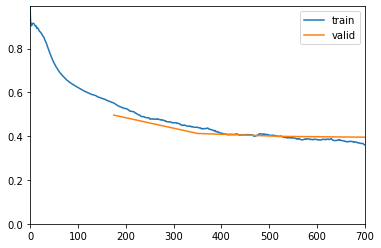

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.526745,0.466832,0.742861,01:33
1,0.422599,0.397609,0.795699,01:33
2,0.386505,0.389930,0.799415,01:38
3,0.358505,0.390571,0.799156,01:33


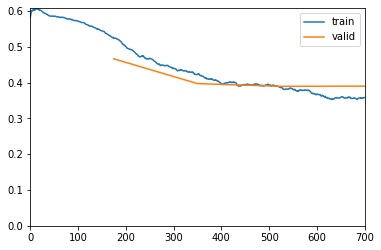

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.497557,0.446416,0.764564,01:34
1,0.419326,0.399493,0.794371,01:33
2,0.392163,0.392511,0.793715,01:33
3,0.357274,0.391096,0.798223,01:33


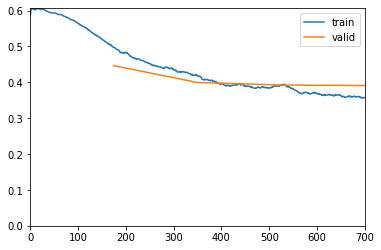

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.513814,0.450327,0.764658,01:33
1,0.425551,0.407524,0.788824,01:33
2,0.392736,0.394647,0.795287,01:33
3,0.368584,0.393786,0.798534,01:33


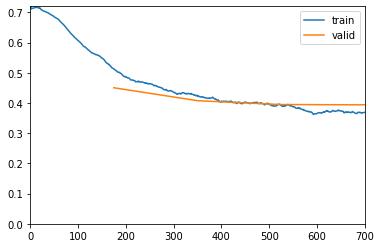

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.543020,0.459808,0.762402,01:33
1,0.431596,0.402712,0.789709,01:33
2,0.388668,0.392719,0.796523,01:37
3,0.365975,0.393283,0.798398,01:33


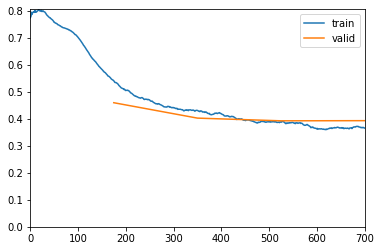

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.510239,0.454455,0.757241,01:33
1,0.427547,0.401459,0.790986,01:33
2,0.388985,0.391909,0.791826,01:33
3,0.360954,0.391884,0.792971,01:34


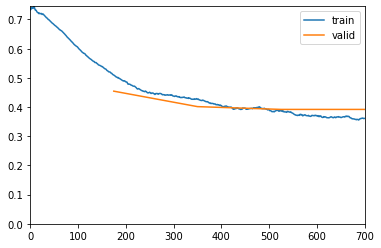

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.523181,0.456801,0.768792,01:33
1,0.430788,0.409026,0.778350,01:33
2,0.389962,0.400815,0.792447,01:33
3,0.364987,0.396817,0.790668,01:34


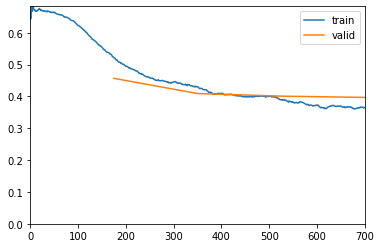

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.526688,0.461286,0.750894,01:34
1,0.418746,0.402513,0.792803,01:33
2,0.376090,0.393467,0.791798,01:34
3,0.350530,0.393334,0.795576,01:33


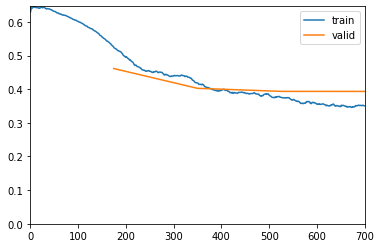

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.544260,0.473626,0.740543,01:34
1,0.431245,0.417744,0.786059,01:33
2,0.391267,0.390505,0.800827,01:36
3,0.370327,0.388047,0.801333,01:33


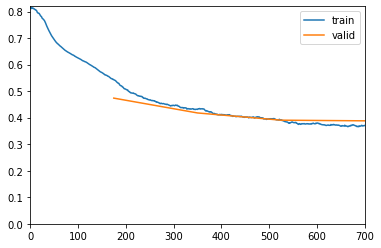

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.509107,0.438703,0.763485,01:33
1,0.421670,0.401699,0.792291,01:33
2,0.381144,0.392019,0.799386,01:34
3,0.359100,0.392117,0.800542,01:33


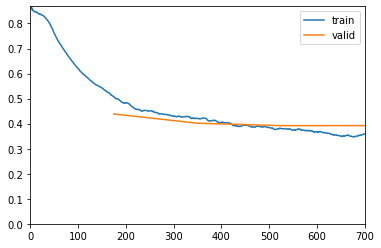

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.508259,0.451075,0.760126,01:34
1,0.423948,0.405624,0.786462,01:33
2,0.392828,0.393188,0.792521,01:34
3,0.376314,0.391086,0.798812,01:33


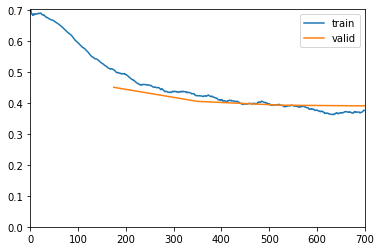

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.537589,0.474941,0.741585,01:33
1,0.432139,0.406567,0.785068,01:33
2,0.397961,0.395624,0.796220,01:33
3,0.373037,0.394144,0.795488,01:33


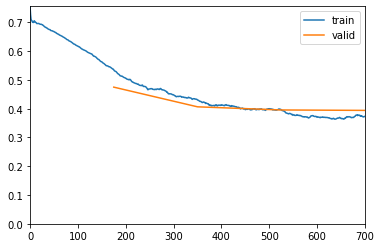

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.513435,0.448174,0.764998,01:33
1,0.431663,0.404858,0.793526,01:34
2,0.391455,0.399620,0.790311,01:34
3,0.356661,0.394408,0.797063,01:33


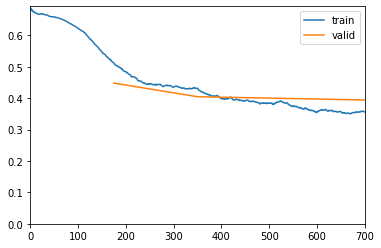

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.535393,0.448280,0.757644,01:35
1,0.416528,0.406288,0.790040,01:34
2,0.379351,0.390757,0.800513,01:33
3,0.352062,0.393258,0.799651,01:33


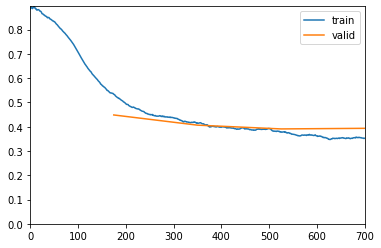

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.523362,0.453940,0.757694,01:34
1,0.428440,0.415307,0.781466,01:34
2,0.388273,0.393550,0.790779,01:34
3,0.361410,0.392958,0.794437,01:34


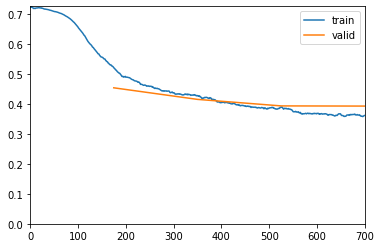

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.512228,0.456678,0.747540,01:36
1,0.425085,0.405156,0.796785,01:35
2,0.393609,0.393181,0.797735,01:35
3,0.363713,0.392167,0.800185,01:37


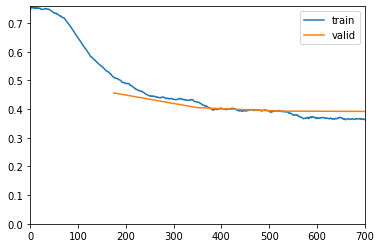

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.542364,0.493265,0.751203,01:35
1,0.439852,0.413281,0.779467,01:35
2,0.392396,0.399323,0.783773,01:35
3,0.366389,0.398297,0.790750,01:35


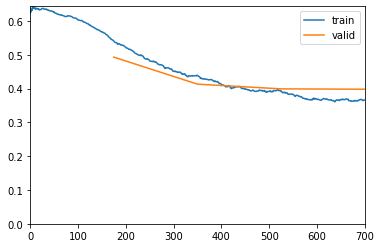

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.499446,0.439066,0.773439,01:35
1,0.420153,0.404712,0.799883,01:37
2,0.381932,0.402147,0.795651,01:35
3,0.347407,0.395962,0.799338,01:35


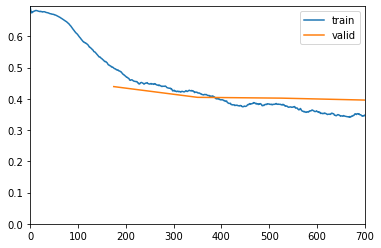

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.505587,0.460380,0.759472,01:35
1,0.425159,0.406618,0.787479,01:35
2,0.392206,0.391195,0.798268,01:35
3,0.365037,0.392895,0.799834,01:35


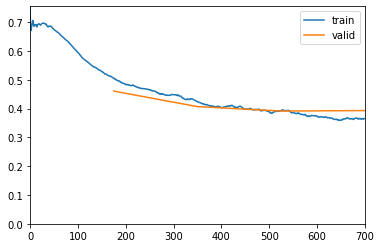

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.504195,0.436699,0.771309,01:35
1,0.426879,0.397622,0.795481,01:35
2,0.385238,0.393364,0.797415,01:35
3,0.351458,0.390805,0.799537,01:35


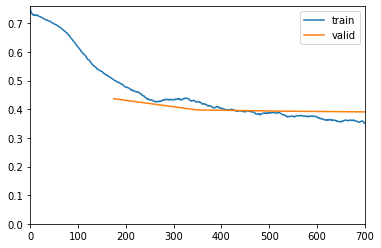

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.518402,0.456702,0.761940,01:36
1,0.423794,0.410645,0.792343,01:35
2,0.385745,0.393035,0.797973,01:35
3,0.352710,0.392637,0.801682,01:35


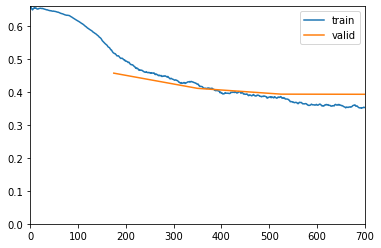

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.558774,0.473061,0.754141,01:35
1,0.438290,0.420044,0.781889,01:35
2,0.390988,0.395134,0.793567,01:37
3,0.372224,0.395465,0.795737,01:36


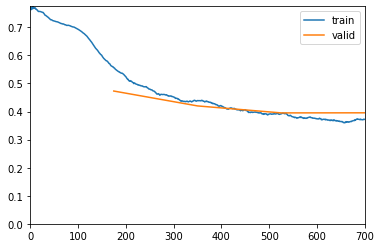

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.541991,0.456815,0.752855,01:34
1,0.425660,0.403105,0.794660,01:33
2,0.388229,0.394583,0.796975,01:36
3,0.361293,0.394258,0.796651,01:35


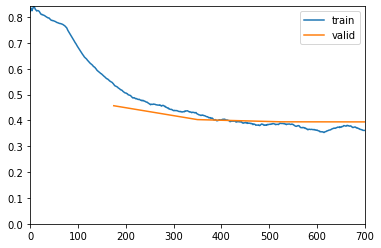

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.531472,0.484777,0.751937,01:35
1,0.429878,0.400313,0.792898,01:35
2,0.387334,0.396877,0.794999,01:35
3,0.367620,0.392489,0.798678,01:35


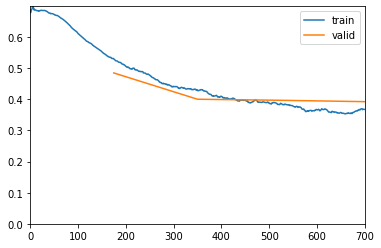

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.534957,0.464195,0.752756,01:36
1,0.427652,0.401205,0.791499,01:37
2,0.392708,0.396210,0.794317,01:36
3,0.368972,0.394660,0.799906,01:35


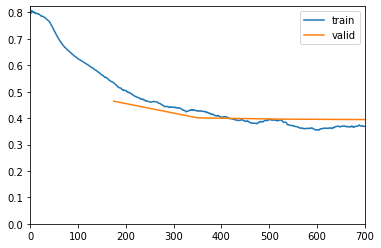

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.522752,0.490106,0.739462,01:36
1,0.432653,0.406678,0.789029,01:36
2,0.391530,0.398070,0.798266,01:35
3,0.361446,0.392765,0.799305,01:36


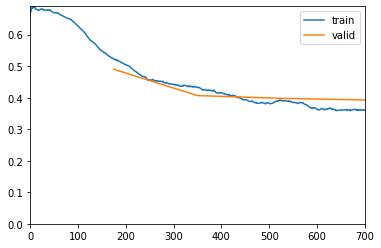

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.514833,0.466664,0.736757,01:36
1,0.429280,0.409250,0.786592,01:35
2,0.393545,0.395212,0.795917,01:35
3,0.365058,0.393661,0.793301,01:35


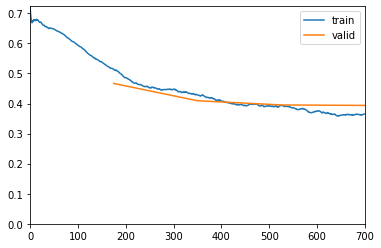

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.505959,0.481169,0.741886,01:35
1,0.428599,0.403854,0.786270,01:35
2,0.379318,0.393425,0.796268,01:35
3,0.352221,0.394334,0.797824,01:35


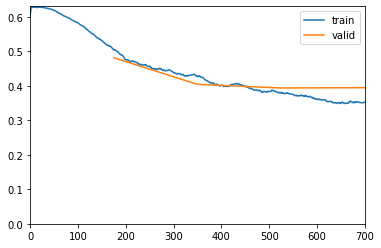

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.512233,0.456504,0.760906,01:35
1,0.428318,0.399598,0.795098,01:35
2,0.391705,0.389816,0.796997,01:35
3,0.364181,0.391777,0.797406,01:34


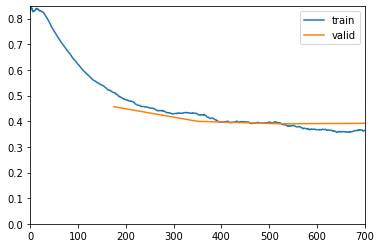

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.523241,0.457093,0.758518,01:35
1,0.432223,0.409300,0.783207,01:35
2,0.394695,0.395851,0.796311,01:35
3,0.361766,0.394334,0.796064,01:35


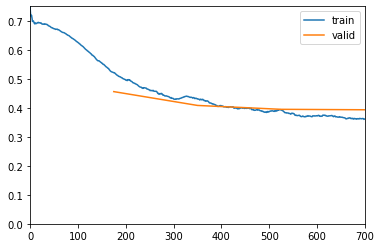

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.544878,0.461778,0.757406,01:36
1,0.429726,0.411763,0.781208,01:35
2,0.391454,0.394837,0.797279,01:35
3,0.371014,0.393541,0.795477,01:35


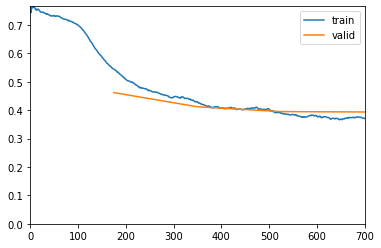

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.526301,0.449794,0.764793,01:35
1,0.429647,0.403495,0.784793,01:35
2,0.386988,0.393014,0.795407,01:35
3,0.371065,0.390987,0.801510,01:35


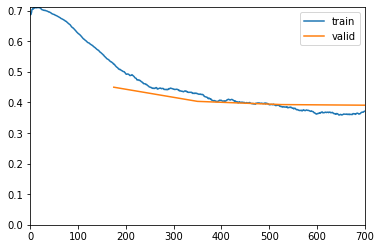

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.512869,0.468542,0.758317,01:34
1,0.428986,0.413917,0.789149,01:35
2,0.388983,0.393413,0.794351,01:33
3,0.363874,0.392835,0.798545,01:37


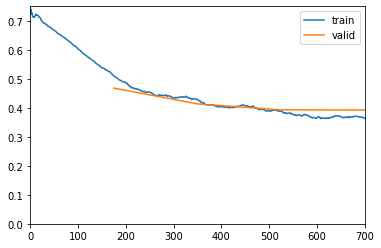

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.514781,0.443937,0.768787,01:35
1,0.423613,0.398926,0.792535,01:35
2,0.390993,0.389672,0.802797,01:35
3,0.352639,0.390093,0.805089,01:35


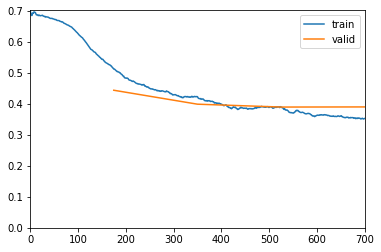

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.554770,0.512988,0.745880,01:35
1,0.439197,0.418168,0.772309,01:35
2,0.399731,0.414272,0.783249,01:35
3,0.370418,0.404512,0.786462,01:35


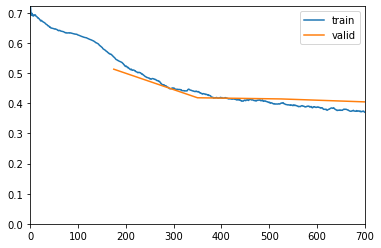

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.578008,0.491873,0.752778,01:35
1,0.440311,0.411503,0.774293,01:36
2,0.398157,0.403616,0.779318,01:36
3,0.363706,0.398591,0.789967,01:36


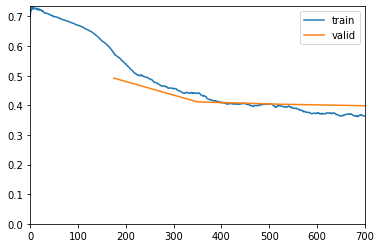

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.502121,0.461173,0.741435,01:36
1,0.428924,0.404175,0.787309,01:35
2,0.387655,0.394876,0.799103,01:35
3,0.355510,0.392108,0.803688,01:35


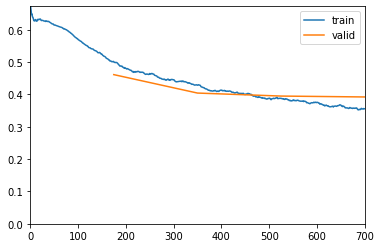

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,fbeta,time
0,0.522476,0.452397,0.761317,01:34
1,0.427345,0.410688,0.791738,01:36
2,0.388956,0.393260,0.801264,01:35


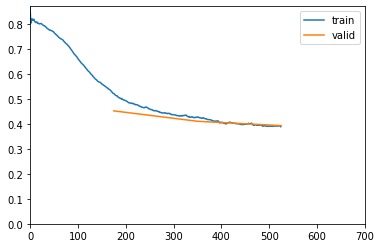

In [ ]:
seed = 0
min_val = 1
for i in range(2,1000000,30):
    seed_all(i)
    loss_func = nn.BCEWithLogitsLoss()
    roberta_model = CustomRobertaModel()
    learn = Learner(data,roberta_model,loss_func=loss_func,metrics=[fbeta],callback_fns=ShowGraph)
    if config.use_fp16: learn=learn.to_fp16()
    learn.lr_find()
    learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
    learn.fit_one_cycle(4, max_lr=config.max_lr)
    val = learn.validate()
    if(val[0]<min_val): 
        min_val=val[0]
        seed = i

In [38]:
print(seed)
print(min_val)
print(i)

NameError: name 'seed' is not defined

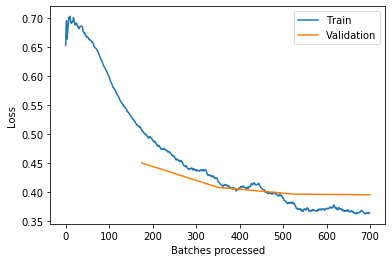

In [38]:
learn.recorder.plot_losses()

In [39]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [40]:
#test_preds = get_preds_as_nparray(DatasetType.Test)
test_preds, test_preds_values = get_preds_as_nparray(DatasetType.Test)

In [41]:
test_preds_values

array([0, 1, 0, 0, ..., 1, 0, 1, 0])

In [42]:
threshold_preds = (test_preds>=0.5).astype(int)
threshold_preds

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [43]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    """
    Args:
        prediction (numpy array)
        sampleFile (str)
        public (boolean)
        filename (str)
    """
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['THEORETICAL'] = list(prediction[:,0]) + [0]*redundant
        submit['ENGINEERING'] = list(prediction[:,1]) + [0]*redundant
        submit['EMPIRICAL'] = list(prediction[:,2]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,3]) + [0]*redundant
    else:
        submit['THEORETICAL'] = [0]*redundant + list(prediction[:,0])
        submit['ENGINEERING'] = [0]*redundant + list(prediction[:,1])
        submit['EMPIRICAL'] = [0]*redundant + list(prediction[:,2])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,3])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [44]:

SubmitGenerator(threshold_preds, 
                'task2_sample_submission.csv',
                True, 
                'task2_submission.csv')

In [ ]:
###pusedo label
dataset[label_cols] = threshold_preds
print(dataset.head())
dataset.to_csv("dataset_predictions.csv", index=False)

In [ ]:
import time
torch.cuda.empty_cache() 
time.sleep(100)